In [53]:
import pandas as pd
import re
import nltk
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopwords corpus
nltk.download('wordnet') # For wordnet
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
train_data=pd.read_csv('./data/bbc_news_train.txt', sep=',')
test_data=pd.read_csv('./data/bbc_news_tests.txt', sep=',')

train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [26]:
train_data.shape

(1490, 3)

In [27]:
train_data.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [28]:
test_data.isna().sum()

Unnamed: 0    0
ArticleId     0
Text          0
Category      0
dtype: int64

In [29]:
category_proportions = train_data['Category'].value_counts()
category_proportions

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

In [30]:


def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN
    
def lemmatize_passage(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    lemmatized_sentence = ' '.join(lemmatized_words)
    return lemmatized_sentence


def preprocessing(text):
    text= text.lower()
    
    text = re.sub('[^a-zA-Z]', ' ', text)

    words= word_tokenize(text)
    
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]

    filtered_phrases=' '.join(filtered_words)
    
    lemmatizer = lemmatize_passage(filtered_phrases)
  
    return  lemmatizer


In [31]:
train_data['Text']= [preprocessing(text) for text in train_data['Text'] ]
test_data['Text']= [preprocessing(text) for text in test_data['Text'] ]


In [32]:
cv = CountVectorizer()

X_train = cv.fit_transform(train_data['Text'])
X_test= cv.transform(test_data['Text'])

In [33]:
replacement = {'sport': 1, 'business': 2, 'politics': 3, 'entertainment': 4, 'tech': 5}

train_data['Category'] = train_data['Category'].apply(lambda x: replacement.get(x, 0))
test_data['Category'] = test_data['Category'].apply(lambda x: replacement.get(x, 0) )

print(replacement.get('business'))
y_train= train_data['Category']
y_test= test_data['Category']

2


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


clf = LogisticRegression(max_iter=10000, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(y_pred[:10])

report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

# 3. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.9796
[1 5 1 2 1 1 3 3 4 2]

Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       165
           2       0.97      0.97      0.97       174
           3       0.97      0.97      0.97       143
           4       0.97      0.98      0.97       113
           5       0.99      0.97      0.98       140

    accuracy                           0.98       735
   macro avg       0.98      0.98      0.98       735
weighted avg       0.98      0.98      0.98       735


Confusion Matrix:
 [[165   0   0   0   0]
 [  0 169   3   2   0]
 [  0   2 139   2   0]
 [  0   1   0 111   1]
 [  1   2   1   0 136]]


In [51]:
# Sauvegardez le modèle dans un fichier
import pickle
with open('topic_classifier.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [52]:
# test load modele
#with open('topic_classifier.pkl', 'rb') as file:
#   model=pickle.load(file)
#   y_pred = model.predict(X_test)
#   accuracy = accuracy_score(y_test, y_pred)
#   print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9796


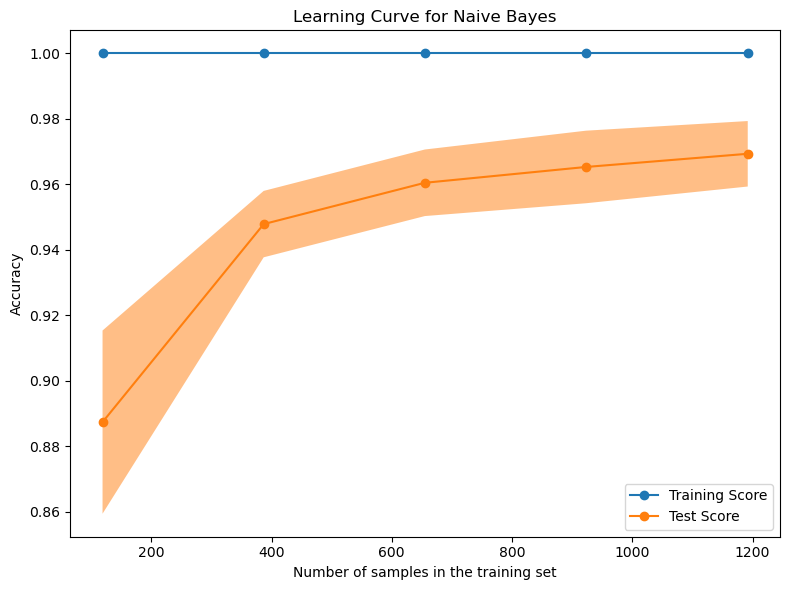

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit


common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),  
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),  
    "score_type": "both",  
    "n_jobs": -1,  
    "line_kw": {"marker": "o"},  
    "std_display_style": "fill_between",  
    "score_name": "Accuracy",  
}


fig, ax = plt.subplots(figsize=(8, 6))

LearningCurveDisplay.from_estimator(clf, **common_params, ax=ax)

handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title("Learning Curve for Naive Bayes")

plt.tight_layout()
plt.show()
